# Preserving a spatial quantity of interest (QoI) with safeguards

In this example, we compute the vorticity on a dataset of wind `u`, `v` vectors, which requires taking the derivative along both variables. We compare how three different lossy compressors (ZFP, SZ3, and SPERR) affect the derived vorticity when compressing the `u` and `v` variables (stacked into one variable). Finally, we apply safeguards to guarantee an error bound on the derived vorticity.

Stacking `u` and `v` into one variable that is then compressed is possible because `u` and `v` have very similar data distributions.

This example also showcases how to deal with boundary conditions in spatial data. For instance, the longitude coordinate is periodic and computing a derivative along the longitude needs to handle the periodic coordinates.

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import numpy as np
import xarray as xr

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5 = ERA5.sel(valid_time="2024-04-02T12:00:00", pressure_level=500)

In [4]:
def compute_vorticity(ERA5: xr.Dataset) -> xr.DataArray:
    earth_radius = 6371000  # [m], globally averaged

    # computing the derivative with a finite difference requires extending the
    #  data domain and tricking xarray for the coordinates
    # e.g. the data needs to be wrapped along the longitude axis,
    #  but the longitude coordinate needs to be extended with odd reflection
    #  ([0, 0.25, ..., 359.75, 360] -> [-0.25, 0, 0.25, ..., 359.75, 360, 360.25])
    #  since xarray cannot handle differentiating along a proper periodic axis
    ERA5_wrapped = (
        ERA5.pad(longitude=1, mode="wrap").pad(
            latitude=1, mode="reflect", reflect_type="even"
        )
    ).assign_coords(
        longitude=ERA5.longitude.pad(longitude=1, mode="reflect", reflect_type="odd"),
        latitude=ERA5.latitude.pad(latitude=1, mode="reflect", reflect_type="odd"),
    )

    # compute the vorticity
    ERA5_dUdTheta = (
        ERA5_wrapped["u"]
        * np.cos(np.deg2rad(ERA5_wrapped["latitude"].astype(ERA5_wrapped["u"].dtype)))
    ).differentiate("latitude")
    ERA5_dVdPhi = ERA5_wrapped["v"].differentiate("longitude")

    ERA5_VOR = (
        earth_radius
        * np.cos(np.deg2rad(ERA5_wrapped["latitude"].astype(ERA5_wrapped["u"].dtype)))
    ) ** (-1) * (ERA5_dVdPhi - ERA5_dUdTheta)

    # remove the padding to extract just the valid values
    ERA5_VOR = ERA5_VOR.sel(longitude=slice(0, 359.9), latitude=slice(89.9, -89.9))
    ERA5_VOR.attrs.update(long_name="vorticity", units="s**-1")

    return ERA5_VOR

In [5]:
ERA5_VOR = compute_vorticity(ERA5)

In [6]:
def plot_vorticity(
    my_ERA5: xr.Dataset,
    cr,
    chart,
    title,
    span,
    error=False,
):
    import copy

    import dask

    my_ERA5_VOR = compute_vorticity(my_ERA5)

    if error:

        def extrema(x):
            amin = np.nanmin(x)
            amax = np.nanmax(x)

            return amin if abs(amin) > abs(amax) else amax

        with xr.set_options(keep_attrs=True):
            da = (my_ERA5_VOR - ERA5_VOR).compute()

        err_U = np.amax(np.abs(my_ERA5["u"] - ERA5["u"]))
        err_V = np.amax(np.abs(my_ERA5["u"] - ERA5["u"]))
        err_VOR = np.amax(np.abs(my_ERA5_VOR - ERA5_VOR))

        da = da.copy(
            data=dask.array.from_array(da.values)
            .rechunk(20)
            .map_blocks(lambda x: np.broadcast_to(extrema(x), x.shape))
            .compute()
        )
        da.attrs.update(long_name=f"{da.long_name} error")
    else:
        da = my_ERA5_VOR

    # compute the default style that earthkit.maps would apply
    source = earthkit.plots.sources.XarraySource(da)
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=source.units,
        )
    )
    style._levels = earthkit.plots.styles.levels.Levels(np.linspace(-span, span, 22))
    style._legend_kwargs["ticks"] = np.linspace(-span, span, 5)
    style._colors = "coolwarm" if error else "RdBu"

    extend = "both" if (np.nanmin(da) < -span) or (np.nanmax(da) > span) else "neither"

    chart.quickplot(da, style=style, extend=extend, zorder=-11)
    chart.ax.set_rasterization_zorder(-10)

    if error:
        chart.title(
            f"{title}\n"
            + rf"$L_{{{{\infty}}}}(\hat{{{{u}}}})$={err_U:.02}  $L_{{{{\infty}}}}(\hat{{{{v}}}})$={err_V:.02}  $L_{{{{\infty}}}}(\hat{{{{\omega}}}})$={err_VOR:.02}"
        )
    else:
        chart.title(f"{title}\n")

    if error:
        t = chart.ax.text(
            0.95,
            0.9,
            f"x {np.round(cr, 2)}",
            ha="right",
            va="top",
            transform=chart.ax.transAxes,
        )
        t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

In [7]:
# Since numcodecs-safeguards only supports single-variable safeguarding, we
# stack the u and v variables into a combined variable.
ERA5_UV = np.stack([ERA5["u"].values, ERA5["v"].values], axis=-1)
ERA5.u.dims, ERA5_UV.shape

(('latitude', 'longitude'), (721, 1440, 2))

## Compressing u and v with lossy compressors

We configure each compressor with an absolute error bound of $10^{-2}$ m/s over the u-v array, which seems to provide similar errors on the derived vorticity.

In [8]:
eb_abs = 0.01

In [9]:
from numcodecs_wasm_zfp import Zfp

zfp = Zfp(mode="fixed-accuracy", tolerance=eb_abs)

ERA5_UV_zfp_enc = zfp.encode(ERA5_UV)
ERA5_UV_zfp = zfp.decode(ERA5_UV_zfp_enc)

ERA5_zfp = ERA5.copy(data=dict(u=ERA5_UV_zfp[..., 0], v=ERA5_UV_zfp[..., 1]))
ERA5_zfp_cr = ERA5_UV.nbytes / ERA5_UV_zfp_enc.nbytes

In [10]:
from numcodecs_wasm_sz3 import Sz3

sz3 = Sz3(eb_mode="abs", eb_abs=eb_abs)

ERA5_UV_sz3_enc = sz3.encode(ERA5_UV)
ERA5_UV_sz3 = sz3.decode(ERA5_UV_sz3_enc)

ERA5_sz3 = ERA5.copy(data=dict(u=ERA5_UV_sz3[..., 0], v=ERA5_UV_sz3[..., 1]))
ERA5_sz3_cr = ERA5_UV.nbytes / ERA5_UV_sz3_enc.nbytes

In [11]:
from numcodecs_wasm_sperr import Sperr

sperr = Sperr(mode="pwe", pwe=eb_abs)

ERA5_UV_sperr_enc = sperr.encode(ERA5_UV)
ERA5_UV_sperr = sperr.decode(ERA5_UV_sperr_enc)

ERA5_sperr = ERA5.copy(data=dict(u=ERA5_UV_sperr[..., 0], v=ERA5_UV_sperr[..., 1]))
ERA5_sperr_cr = ERA5_UV.nbytes / ERA5_UV_sperr_enc.nbytes

## Compressing u and v using the safeguards-wrapped lossy compressors

We configure the safeguards to bound the pointwise absolute error on the derived vorticity, choosing an error bound of $10^{-6}$ 1/s that is reasonable for the range of the computed baseline vorticity.

The vorticity computation is translated into a quantity of interest over a small local neighbourhood, in which the first-order, second-order-accuracy finite difference is used to approximate the spatial derivatives. For the derivative along the longitude axis, we specify that the coordinates are periodic with a period of 360 degrees to ensure the finite difference on the arbitrary grid is not confused by the coordinate jump at the longitude wrap-around from 0 to 360 degrees.

In [12]:
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_zero import ZeroCodec

ERA5_sg = dict()
ERA5_sg_cr = dict()

for codec in [
    ZeroCodec(),
    zfp,
    sz3,
    sperr,
]:
    sg = SafeguardsCodec(
        codec=codec,
        safeguards=[
            dict(
                kind="qoi_eb_stencil",
                qoi="""
                let(
                    V["earth_radius"], 6371000,  # [m], globally averaged
                )
                
                (let(
                    # extract u and v from the last stacked dimension
                    V["u"], X[I[0], I[1], 0],
                    V["v"], X[I[0], I[1], 1],
                    # convert latitude in degrees to radians
                    V["latRad"], c["lat"] * pi / 180,
                )
    
                (let(
                    # approximate the spatial derivatives with finite differences
                    V["dUdTheta"], finite_difference(V["u"] * cos(V["latRad"]), order=1, accuracy=2, type=0, axis=0, grid_centre=c["lat"]),
                    V["dVdPhi"], finite_difference(V["v"], order=1, accuracy=2, type=0, axis=1, grid_centre=c["lon"], grid_period=360),
                )
                
                (
                    # compute the vorticity
                    (V["earth_radius"] * cos(V["latRad"])) ** (-1) * (V["dVdPhi"] - V["dUdTheta"])
                )))
                """,
                type="abs",
                eb=1e-6,
                neighbourhood=[
                    # latitude
                    dict(axis=0, before=1, after=1, boundary="reflect"),
                    # longitude
                    dict(axis=1, before=1, after=1, boundary="wrap"),
                    # [u, v]
                    dict(axis=-1, before=0, after=1, boundary="valid"),
                ],
            )
        ],
        fixed_constants=dict(
            lat=ERA5.latitude.values.reshape(-1, 1, 1),
            lon=ERA5.longitude.values.reshape(1, -1, 1),
        ),
    )

    ERA5_UV_sg_enc = sg.encode(ERA5_UV)
    ERA5_UV_sg = sg.decode(ERA5_UV_sg_enc)

    ERA5_sg[codec.codec_id] = ERA5.copy(
        data=dict(u=ERA5_UV_sg[..., 0], v=ERA5_UV_sg[..., 1])
    )
    ERA5_sg_cr[codec.codec_id] = ERA5_UV.nbytes / np.asarray(ERA5_UV_sg_enc).nbytes

## Visual comparison of the error distributions for the derived vorticity

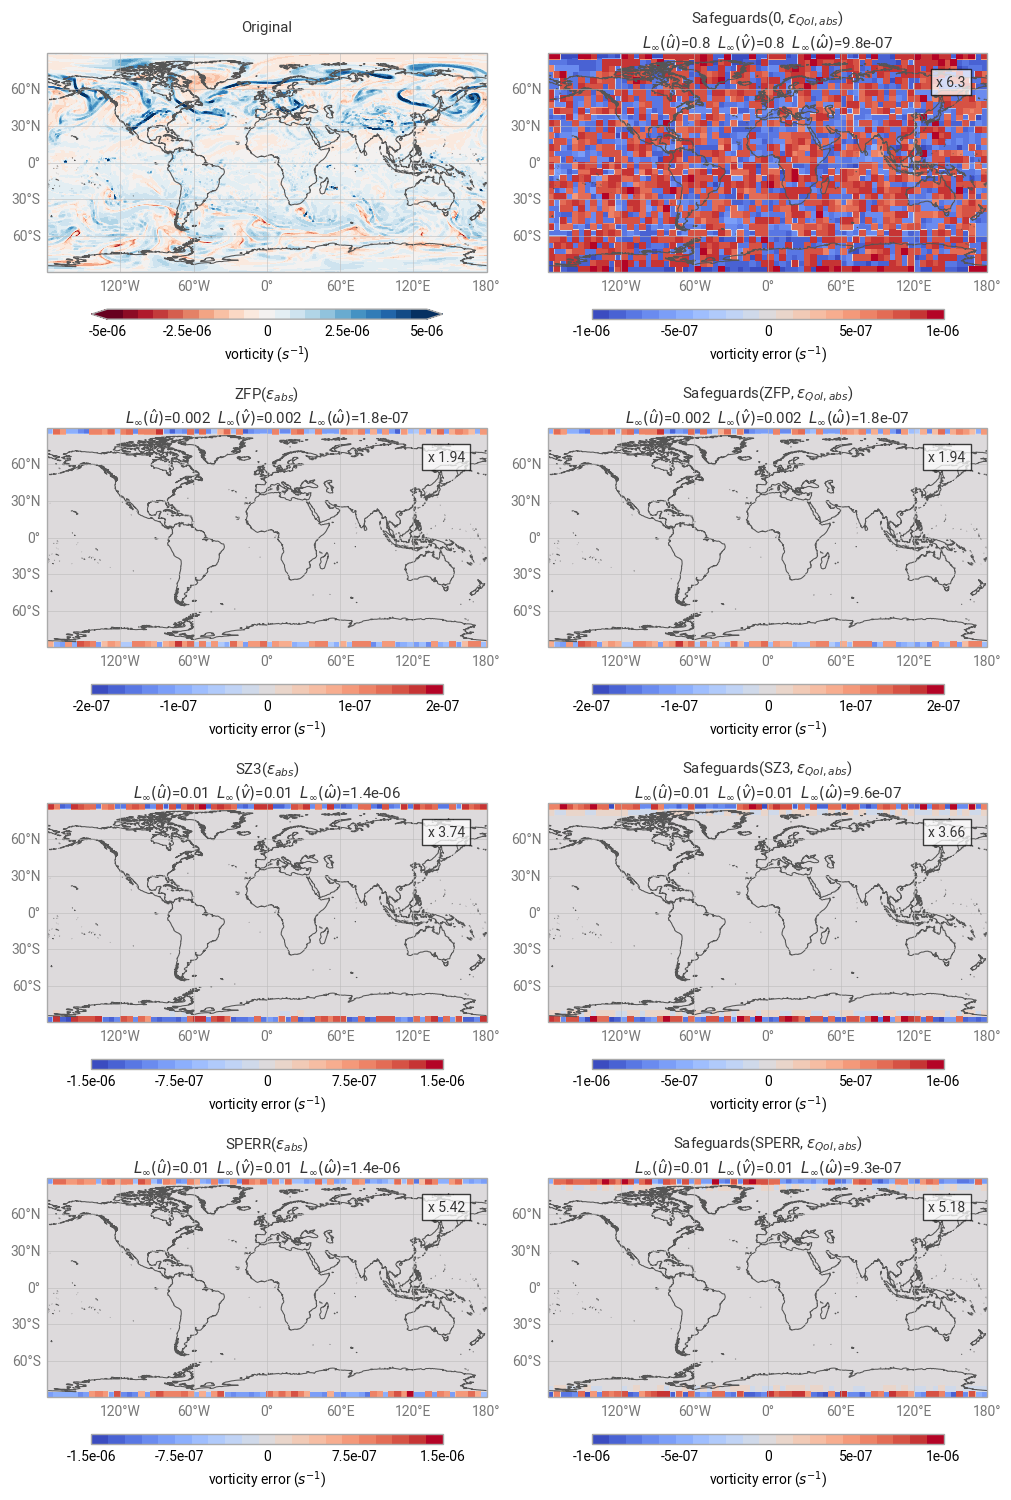

In [14]:
fig = earthkit.plots.Figure(
    size=(10, 15),
    rows=4,
    columns=2,
)

plot_vorticity(ERA5, 1.0, fig.add_map(0, 0), "Original", span=5e-6)
plot_vorticity(
    ERA5_zfp,
    ERA5_zfp_cr,
    fig.add_map(1, 0),
    r"ZFP($\epsilon_{{abs}}$)",
    span=2e-7,
    error=True,
)
plot_vorticity(
    ERA5_sz3,
    ERA5_sz3_cr,
    fig.add_map(2, 0),
    r"SZ3($\epsilon_{{abs}}$)",
    span=1.5e-6,
    error=True,
)
plot_vorticity(
    ERA5_sperr,
    ERA5_sperr_cr,
    fig.add_map(3, 0),
    r"SPERR($\epsilon_{{abs}}$)",
    span=1.5e-6,
    error=True,
)

plot_vorticity(
    ERA5_sg["zero"],
    ERA5_sg_cr["zero"],
    fig.add_map(0, 1),
    r"Safeguards(0, $\epsilon_{{QoI,abs}}$)",
    span=1e-6,
    error=True,
)
plot_vorticity(
    ERA5_sg["zfp.rs"],
    ERA5_sg_cr["zfp.rs"],
    fig.add_map(1, 1),
    r"Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)",
    span=2e-7,
    error=True,
)
plot_vorticity(
    ERA5_sg["sz3.rs"],
    ERA5_sg_cr["sz3.rs"],
    fig.add_map(2, 1),
    r"Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)",
    span=1e-6,
    error=True,
)
plot_vorticity(
    ERA5_sg["sperr.rs"],
    ERA5_sg_cr["sperr.rs"],
    fig.add_map(3, 1),
    r"Safeguards(SPERR, $\epsilon_{{QoI,abs}}$)",
    span=1e-6,
    error=True,
)

fig.save("vorticity.pdf")